<a href="https://colab.research.google.com/github/patty-13/DEEP_LEARNING_NJIT/blob/main/HW10_DEEPLEARNING_PART1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 10 - Reinforcement Learning**




## Preliminary work

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.

In [ ]:
!apt update
!pip install -q swig
!pip install box2d==2.3.2 gym[box2d]==0.25.2 box2d-py pyvirtualdisplay tqdm numpy==1.22.4
!pip install box2d==2.3.2 box2d-kengz
!pip freeze > requirements.txt

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,538 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,302 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/mai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.4/425.4 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-kengz: filename=Box2D_kengz-2.3.3-cp310-cp310-linux_x86_64.whl size=2391292 sha256=de93b4f22ef137488b1009e7f678b66bb79d21a5f6fa5775bc124660ae2928ec
  Stored in directory: /root/.cache/pip/wheels/ab/a3/5f/6396406aa0163da86c2a8d28304a120b55cfa98363654d853b
Successfully built box2d-kengz


In [ ]:
!apt install xvfb -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 15 not upgraded.
Need to get 7,814 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv


Next, set up virtual display，and import all necessaary packages.

In [ ]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# Warning ! Do not revise random seed !!!
Make your HW result to be reproducible.


In [ ]:
seed = 2023 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [ ]:
%%capture
import gym
import random
env = gym.make('LunarLander-v2')
fix(env, seed) # fix the environment Do not revise this !!!

## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.

This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment".

In this homework, we will utilize the function `step()` to control the action of "Agent".

Then `step()` will return the observation/state and reward given by the "Environment".

### Observation / State

First, we can take a look at what an Observation / State looks like.

In [ ]:
print(env.observation_space)

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [ ]:
print(env.action_space)

Discrete(4)


`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment.
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.

In [ ]:
initial_state = env.reset()
print(initial_state)

[-0.00506535  1.413064   -0.5130838   0.09527162  0.00587628  0.11622101
  0.          0.        ]


Then, we try to get a random action from the agent's action space.

In [ ]:
random_action = env.action_space.sample()
print(random_action)

1


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [ ]:
observation, reward, done, info = env.step(random_action)

In [ ]:
print(done)

False


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100-140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points.

In [ ]:
print(reward)

-1.4981841929643156


### Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.

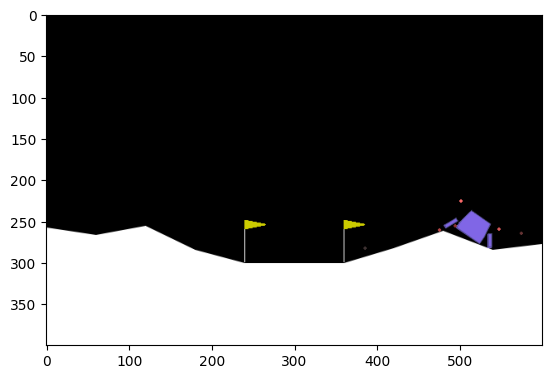

In [ ]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Policy Gradient
Now, we can build a simple policy network. The network will return one of action in the action space.

In [ ]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(hid)
        return F.softmax(self.fc3(hid), dim=-1)

Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities.

In [ ]:
from torch.optim.lr_scheduler import StepLR
class PolicyGradientAgent():

    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.002)

    def forward(self, state):
        return self.network(state)
    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum() # You don't need to revise this to pass simple baseline (but you can)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

Lastly, build a network and agent to start training.

In [ ]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

class DQNet(nn.Module):
  def __init__(self, n_states, n_actions):
    super(DQNet, self).__init__()

    self.fc = nn.Sequential(
        nn.Linear(n_states, 128),
        nn.LeakyReLU(),
        nn.Linear(128, 128),
        nn.LeakyReLU(),
        nn.Linear(128, 128),
        nn.LeakyReLU(),
        nn.Linear(128, n_actions)
    )
  def forward(self, x):
    return self.fc(x)

class ReplayBuffer():
  def __init__(self, n_actions, memory_size, batch_size):
    self.n_actions = n_actions
    self.batch_size = batch_size
    self.memory = deque(maxlen = memory_size)
    self.experience = namedtuple("Experience", field_names=["state","action","reward","next_state","done"])

  def __len__(self):
    return len(self.memory)

  def push(self, state, action, reward, next_state, done):
    e = self.experience(state, action, reward, next_state, done)
    self.memory.append(e)

  def sample(self):
    experience = random.sample(self.memory, k = self.batch_size)

    states = torch.from_numpy(np.vstack([e.state for e in experience if e is not None])).float().to(device)
    actions = torch.from_numpy(np.vstack([e.action for e in experience if e is not None])).long().to(device)
    rewards = torch.from_numpy(np.vstack([e.reward for e in experience if e is not None])).float().to(device)
    next_states = torch.from_numpy(np.vstack([e.next_state for e in experience if e is not None])).float().to(device)
    dones = torch.from_numpy(np.vstack([e.done for e in experience if e is not None]).astype(np.uint8)).float().to(device)
    return (states, actions, rewards, next_states, dones)


In [ ]:
class DQNAgent():
  def __init__(self, n_states, n_actions, batch_size =64, lr =1e-3, gamma = 0.99, mem_size = int(1e5), learn_step =5, tau = 1e-3):
    self.n_states = n_states
    self.n_actions = n_actions
    self.batch_size = batch_size
    self.gamma = gamma
    self.learn_step =learn_step
    self.tau = tau

    # MODEL CALLING
    self.main_q_network = DQNet(n_states, n_actions).to(device)
    self.target_q_network = DQNet(n_states, n_actions).to(device)
    self.optimizer = optim.Adam(self.main_q_network.parameters(), lr = lr)
    self.criterion = nn.MSELoss()

    #MEMORY

    self.memory = ReplayBuffer(n_actions, mem_size, batch_size)
    self.counter = 0

  def getAction(self, state, epsilon):
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)

    self.main_q_network.eval()
    with torch.no_grad():
      action_values = self.main_q_network(state)
    self.main_q_network.train()


    if random.random() < epsilon:
      action = random.choice(np.arange(self.n_actions))
    else:
      action = np.argmax(action_values.cpu().data.numpy())

    return action

  def save_in_memory(self, state, action, reward, next_state, done):
    self.memory.push(state, action, reward, next_state, done)

    self.counter += 1
    if self.counter % self.learn_step == 0:
      if len(self.memory) >= self.batch_size:
        experiences = self.memory.sample()
        self.learn(experiences)

  def learn(self, experiences):
    states, actions, rewards, next_states, dones = experiences

    target = self.target_q_network(next_states).detach().max(axis = 1)[0].unsqueeze(1)
    y = rewards + self.gamma * target * ( 1 - dones)
    eval =self.main_q_network(states).gather(1, actions)


    loss = self.criterion(eval, y)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    self.softUpdate()

  def softUpdate(self):
    for eval_param, target_param in zip(self.main_q_network.parameters(), self.target_q_network.parameters()):
      target_param.data.copy_(self.tau * eval_param + (1.0 - self.tau) * target_param.data)


In [ ]:
from tqdm import trange

# best_score = 0
# best_batch = 0
# avg_total_rewards = []
# avg_final_rewards = []

def train(env, agen, n_episodes = 4000, max_steps = 1000, eps_start = 1.0, eps_end =0.01, eps_decay = 0.998, target = 200, chkpt = False):
  epsilon = eps_start
  bar_format = '{l_bar}{bar:10}| {n:4}/{total_fmt} [{elapsed:>7}<{remaining:>7}, {rate_fmt}{postfix}]'
  score_hist = []

  pbar = trange(n_episodes, unit = "ep", bar_format = bar_format, ascii = True)

  for idx in pbar:
    state = env.reset()
    score = 0

    for idx_step in range(max_steps):
      action = agent.getAction(state, epsilon)
      next_state, reward, done, _ = env.step(action)
      agent.save_in_memory(state, action, reward, next_state, done)
      state = next_state
      score += reward

      if done:
        break

    score_hist.append(score)
    score_avg = np.mean(score_hist[100:])
    epsilon = max(eps_end, epsilon * eps_decay)

    pbar.set_postfix_str(f"Score: {score: 7.2f}, 100 score avg: {score_avg: 7.2f}")
    pbar.update(0)


    if len(score_hist) >= 100:
      if score_avg >= target:
        break

  if(idx + 1) < n_episodes:
    print("Target reached")
  else:
    print("Done")

  if chkpt:
    torch.save(agent.main_q_network.state_dict(), 'checkpoint.pth')
  return score_hist

In [ ]:
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
BATCH_SIZE = 128
LR = 5e-4
EPISODES = 4500
TARGET_SCORE = 260
GAMMA = 0.99
MEMORY_SIZE = 10000
LEARN_STEP = 4
TAU = 1e-3
SAVE_CHKPT = False
agent = DQNAgent(
    n_states = num_states,
    n_actions = num_actions,
    batch_size = BATCH_SIZE,
    lr = LR,
    gamma = GAMMA,
    mem_size = MEMORY_SIZE,
    learn_step = LEARN_STEP,
    tau = TAU,
    )
score_hist = train(env, agent, n_episodes=EPISODES, target=TARGET_SCORE, chkpt=SAVE_CHKPT)
#plotScore(score_hist)

if str(device) == "cuda":
    torch.cuda.empty_cache()

100%|##########| 4500/4500 [1:06:40<  00:00,  1.12ep/s, Score:   61.18, 100 score avg:  179.36]

Done


## Training Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,

### Training Result
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:  


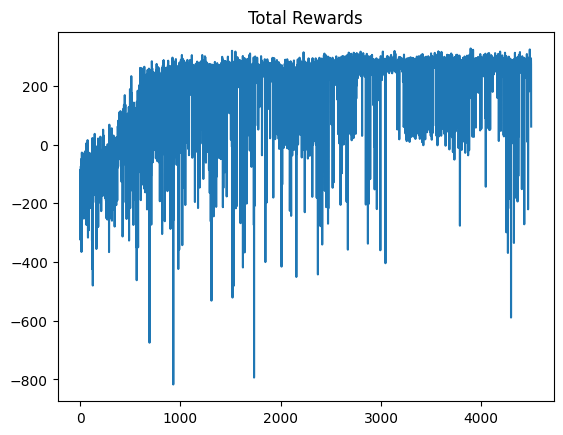

In [ ]:
plt.plot(score_hist)
plt.title("Total Rewards")
plt.show()

In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


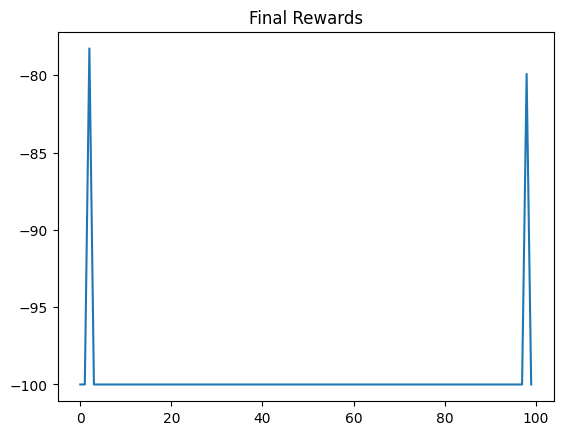

In [ ]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

## Testing
The testing result will be the average reward of 5 testing

260.3983947964059


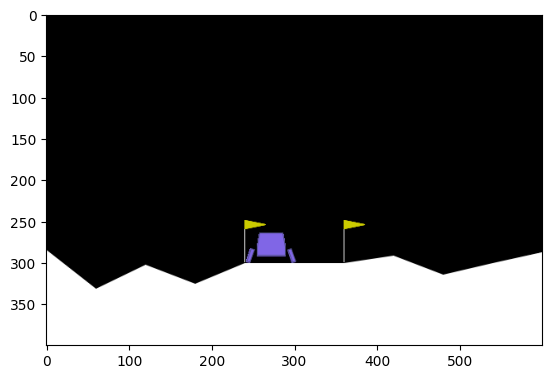

In [ ]:
fix(env, seed)
NUM_OF_TEST = 5
agent.main_q_network.eval()
test_total_reward = []
action_list = []

for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()
  img = plt.imshow(env.render(mode = 'rgb_array'))
  total_reward = 0
  done = False

  while not done:
    action = agent.getAction(state, epsilon  = 0)
    actions.append(action)
    state, reward, done, _ = env.step(action)
    total_reward += reward

    img.set_data(env.render(mode = 'rgb_array'))
    display.display(plt.gcf)
    display.clear_output(wait = True)
  print(total_reward)
  test_total_reward.append(total_reward)
  action_list.append(actions)

In [ ]:
print(test_total_reward)
print(np.mean(test_total_reward))

[260.76204277997675, 254.76917581012424, 258.0457618413982, 284.5894769325182, 260.3983947964059]
263.71297043208466


Action list

In [ ]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Action list looks like  [[3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 3, 2, 0, 3, 3, 1, 3, 3, 2, 3, 1, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 2, 2, 3, 3, 2, 2, 3, 2, 3, 2, 2, 2, 3, 1, 2, 3, 2, 2, 2, 3, 1, 3, 1, 2, 2, 3, 1, 1, 2, 2, 2, 3, 1, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Analysis of actions taken by agent

In [ ]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

{3: 105, 0: 330, 2: 338, 1: 104}


Saving the result of Model Testing


In [ ]:
PATH = "ACTION_LIST_1.npy" # Can be modified into the name or path you want
np.save(PATH ,np.array(action_list))

<ipython-input-91-a6fa04ad8334>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(PATH ,np.array(action_list))


### This is the file you need to submit !!!
Download the testing result to your device



In [ ]:
from google.colab import files
files.download(PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Reproduction for Evaluation
The code below simulates the environment and is used for grading.

Your reward is : 276.98
Your reward is : 314.05
Your reward is : 250.99
Your reward is : 284.00
Your reward is : 289.98


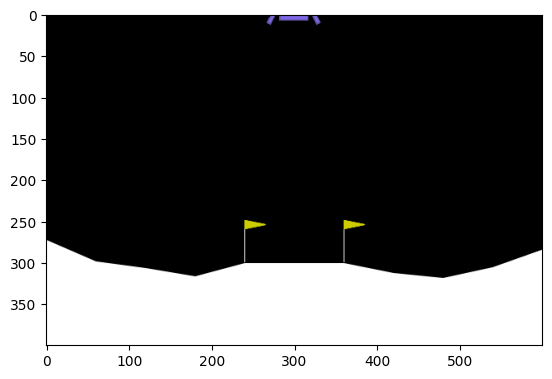

In [ ]:
action_list = np.load('/content/ACTION_LIST_1.npy',allow_pickle=True) # The action list you submit
seed = 2023 # Do not revise this
fix(env, seed)

#agent.main_q_network.eval()  # set network to evaluation mode

test_total_reward = []
if len(action_list) != 5:
  print("Wrong format of file !!!")
  exit(0)
for actions in action_list:
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False

  for action in actions:

      state, reward, done, _ = env.step(action)
      total_reward += reward
      # img.set_data(env.render(mode='rgb_array'))
      # display.display(plt.gcf())
      # display.clear_output(wait=True)
      if done:
        break

  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

# Your score

In [ ]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : 283.20
